<a href="https://colab.research.google.com/github/gtbook/robotics/blob/main/S72_drone_actions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%pip install -q -U gtbook


Note: you may need to restart the kernel to use updated packages.


In [9]:
import math
import numpy as np
import pandas as pd

import plotly.express as px
try:
    import google.colab
except:
    import plotly.io as pio
    pio.renderers.default = "png"

import gtsam
from gtbook.drone import axes


# Multi-rotor Aircraft

> An amazing way to fly in 3D.

<img src="Figures7/S72-Autonomous_camera_drone-06.jpg" alt="Splash image with steampunk drone in various poses" width="40%" align=center style="vertical-align:middle;margin:10px 0px">

The dynamics and kinematics of quadrotors and in general *multi*-rotor aircraft are those of simple rigid 3D bodies. Many different coordinate frame conventions are used in the literature. We introduce one good choice below, and convert equations from the literature to this convention where needed.

The equations for control and navigation we develop below are most useful when expressed in a local **navigation frame** $N$. For MAV applications this frame is almost always assumed to be non-rotating and aligned with gravity, but can otherwise be defined arbitrarily, e.g., **East-North-Up (ENU)**. The origin of the navigation frame is often chosen as the take-off point, but does not have to be. Another choice is the UTM (Universal Transverse Mercator) coordinate system, which defines 60 locally flat coordinate frames on earth.

We also define a **body frame** $B$ as having its origin at the center of mass of the vehicle. We fix the X-axis as pointing to the front of the vehicle (not always the direction of travel), the Y-axis as pointing to the left, and the Z-axis pointing up, the so-called **FLU convention**. In aerospace applications the so-called FRD convention with the Z-axis *down* is also popular, but it really is just matter of choice, and we find FLU to be more intuitive.

We then define, respectively,

• the vehicle's *position* $r^{n}\doteq[x,y,z]^{T}$,

• its linear velocity $v^n=\dot{r^{n}}\doteq[u,v,w]^{T}$,

• the attitude $R^n_b\doteq[i^b,j^b,k^b]\in SO(3)$, a $3\times 3$ rotation matrix with the columns of the body frame $B$ expressed in the navigation frame $N$,

• the body angular velocity $\omega^b\doteq[p,q,r]^{T}$.

Above the superscript $n$ and $b$ denote quantities expressed in the *navigation* and *body* frame, respectively. Together, these quantities allow us to talk about the *kinematics* of the drone: where it is and how it moves over time.

## Drone Dynamics

Kinematics alone is not enough, however: because an MAV has *mass*, we need to talk about how forces will bring about change in the velocity. One of us (Dellaert) has worked at the drone startup [Skydio](https://www.skydio.com/) and hence we will use one of its products as a prototypical example.

<figure id="fig:Skydio">
<img src="https://github.com/gtbook/robotics/blob/main/Figures7/Skydio2axes.png?raw=1" style="width:18cm" alt="">
<figcaption>Skydio 2 drone with *Front-Left-Up* coordinate frame, and rotors labeled with coordinates. </figcaption>
</figure>

In particular, let us take the [Skydio 2+](https://www.skydio.com/skydio-2-plus) as a relevant example. Its mass, with battery, is about $800g$, but let's just say $1kg$ to make the calculations easier. Its dimensions are $229mm \times 274mm$, but let us assume the motors are at $(+/- 0.10m, +/- 0.10m)$, which is not too far off. The figure above shows the setup.

### Hover
To hover, assuming we approximate the local gravity constant as $g=10m/s^2$, the four rotors *together* have to provide a thrust of 10N upwards to compensate for gravity, i.e., 2.5N per motor. Of course, we need to be able to accelerate upwards, so let's assume each motor can provide up to double that, i.e., 0 to 5N. So, while the drone is level, here are some sample accelerations we can deliver:

- $f_i=0N$ for $i\in{1..4}$: downwards acceleration at $-10\frac{m}{s^2}$.
- $f_i=2.5N$ for $i\in{1..4}$: stable hover $0\frac{m}{s^2}$.
- $f_i=5N$ for $i\in{1..4}$: upwards acceleration at $10\frac{m}{s^2}$.

In general, the force $F^b_z$ delivered by the rotors is aligned with the body Z-axis and is equal to

$$
F^b_z = \sum_{i=1}^4 f_i.
$$

As long as the drone is level, and hence the body Z-axis is aligned with gravity, we can only accelerate up or down. The net acceleration in that case is obtained simply by subtracting the acceleration due to gravity. But, of course, only being to move up or down is not very useful, and is unlikely to happen anyway because of noise, wind, and other effects. Hence, below we look at how 3D orientation plays a role.

### Forward Flight

The thrust delivered by the rotors is always aligned with the body frame $B$'s Z-axis, and hence by rotating the quadrotor appropriately we can achieve any thrust direction in the navigation frame $N$ we desire. For example, when we *tilt* the quadrotor forwards, we will direct some of the thrust delivered by the rotors towards generating horizontal acceleration. To get a handle on this, we need to calculate the thrust in the *navigation* frame $N$. This is accomplished by multiplying the 3D force $F^b$ in the body frame with the rotation matrix $R^n_b$:

$$
F^n = R^n_b \begin{bmatrix}0 \\ 0 \\ F^b_z\end{bmatrix} = \hat{z}^n_b F^b_z.
$$

Above $\hat{z}^n_b$ is the third column of $R^n_b$, i.e., this is simply the Z-axis $\hat{z}$ of the body frame $B$, expressed in the navigation frame $N$.

As an example, let us assume that the Forward/X-axis of the FLU body frame is currently oriented along the North/Y-axis of the ENU navigation frame, i.e., we are flying North. Then, if we tilt the body's Up/Z-axis forward by an angle of $\theta$ with respect to vertical, the body Z-axis will have a $\sin \theta$ contribution towards the north (ENU Y-axis), and a $\cos \theta$ up (ENU Z-axis):

$$
\hat{z}^n_b = \begin{bmatrix}0 \\ \sin \theta \\ \cos \theta\end{bmatrix}.
$$

The thrust *vector* $F^n$ in the navigation frame is then obtained by multiplying with the total force $F^b_z$:
$$
F^n = \begin{bmatrix}0 \\ \sin \theta \\ \cos \theta\end{bmatrix} F^b_z.
$$

The fact that $\cos \theta<1$ is potentially problematic: if we want to maintain level flight (not fall out of the sky!) we need to compensate for gravity by maintaining the constraint

$$
\cos \theta F^b_z = 10N.
$$

That in turn means that the forward trust (along the navigation Y-axis) will be

$$
F^n_y = \sin \theta F^b_z = \sin \theta \frac{10N}{\cos \theta} = \tan \theta \cdot 10N 
$$

This point bears repeating: if we tilt the drone to fly in a particular direction, the upward component of the thrust vector decreases, so we will have to *increase* total thrust, or we will lose altitude.

### Maximum Tilt and Thrust

We can expand on this example to calculate what our maximum tilt angle would be, given bounded thrust. We are constrained by the maximum thrust $F^b_z$ we can deliver, which we assumed to be 20N above. Imposing this constraint in turn yields a constraint on $\cos \theta$:

$$
F^b_z = \frac{10N}{\cos \theta} \leq 20N \rightarrow \cos \theta \geq 0.5
$$

From that we can deduce that the maximum tilt angle $\theta$ is 60 degrees:

$$
-60^\circ \leq \theta \leq 60^\circ,
$$

At that maximum tilt angle, we have

$$
F^n_y = \tan \theta_{\max} \cdot 10N \approx 17N 
$$

So, we are limited to $17N$ of forward thrust, and this when tilting very aggressively at 60 degrees. If we tilt more, we can improve thrust even more (up to 20N) but the drone will lose altitude fast. 

### Drag and Maximum Velocity

Because of *drag*, constant forward thrust does *not* mean that the drone will continue accelerating. From the spec-sheet of the Skydio 2 drone we see that the top speed in autonomous mode is 36Mph, which is about $16m/s$, and the theoretical top speed is probably more like $20m/s$. From physics we know that drag increases *quadratically* with velocity, and hence we can calculate the corresponding drag coefficient. Indeed, the drag force $k_d v_{top}^2$ at the top speed has to exactly balance the maximum forward thrust of 17N:

$$
k_d v_{top}^2 = 17N 
$$

If we assume the top speed of $20m/s$ is correct, we can estimate the drag coefficient $k_d$:

$$
k_d 20^2= 17 \rightarrow k_d = 0.0425
$$

Given the drag coefficient $k_d$, we can calculate a simple mapping from tilt angle $\theta$ to the terminal forward velocity. For a given tilt angle $\theta$ we first calculate the forward thrust $F^n_y$ in the navigation frame:

$$
F^n_y = \tan \theta \cdot 10N
$$

after which the velocity can be obtained by equating that to the drag force $k^d v^2$:

$$
\tan \theta \cdot 10N = k_d v^2 \rightarrow v = \sqrt{\frac{\tan \theta \cdot 10}{k_d}}
$$

Plugging in the estimated value of $k_d$ we obtain

$$
v \approx 15 \sqrt{\tan \theta}
$$

With a smidgen of code we can build a lookup table `vmap`...

In [10]:
vmap = {}
for theta_deg in [0,1,5,10,15,20,30,40,50, 60]:
  theta_rad = math.radians(theta_deg)
  vmap[theta_deg] = 15. * math.sqrt(math.tan(theta_rad))


...and plot it below:

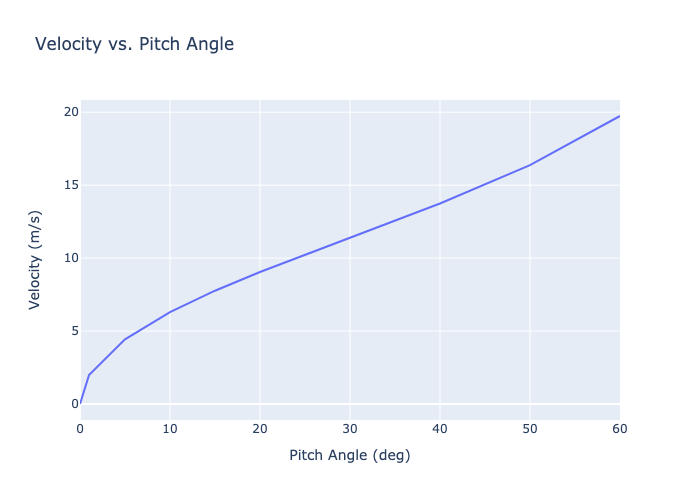

In [11]:
px.line(x=list(vmap.keys()), y= list(vmap.values()), title="Velocity vs. Pitch Angle",
        labels={"x":"Pitch Angle (deg)", "y":"Velocity (m/s)"})


## Drone Kinematics

The **kinematics** of the drone deal exclusively with velocities, not the forces and accelerations involved to obtain those velocities. Kinematics should be contrasted with **statics** or steady-state force reasoning as we did above, and **dynamics** which describes the changing forces and accelerations over time.

### Positional Kinematics

For position, the vehicle's kinematics are given by stating that the time derivative $\dot{r}^{n}$ of position $r^n$ in the navigation frame $N$ is equal to the **linear velocity** $v^n$, also in the navigation frame:

$$
\dot{r}^{n}	= v^n.
$$

### Angular Velocity

Just as we have a linear velocity $v^n$, a three-vector, we also have a 3-dimensional **angular velocity** $\omega$, but it is typically given *in the body frame* as $\omega^b$, because each of the components corresponds to angular velocities around the respective body axes. This angular velocity vector has a very intuitive interpretation as an angle-axis interpretation: the vector can be viewed as a rotation axis in 3D, centered at the body coordinate frame, and its norm $\|\omega^b\|$ is the instantaneous angular velocity around that axis. 

For example, if the drone is steadily pitching downward by 10 degrees/second, this is a positive rotation around the body Y-axis and the corresponding angular velocity is

$$
\omega^b = \begin{bmatrix}0 \\ 1 \\ 0\end{bmatrix} 10 \frac{\pi}{180}.
$$

We know it has to be positive, as by convention a positive angular velocity around a given axis is defined to be counter-clockwise, when looking from that axis towards the origin. remember that in our FLU convention the Y-axis points leftward from the center of the drone, and hence looking from the left a counter-clockwise movement corresponds to pitching *down*.

In an FLU body frame, each of the axes is associated with a particular rotational motion:

- **roll** is around the Forward/X-axis. Positive roll is to the right.
- **pitch** is around the Left/Y-axis. Positive pitch is downward.
- **yaw** is around the Up/Z-axis. Positive yaw is towards the left.

Note that the statements associated with positive roll, pitch or yaw above are valid only when starting from upright hover. For example, when flying upside down, obviously yaw and pitch would behave opposite.

#### Exercise

When flying upside down but in the same direction, positive roll is still to thr right. Think about it.

### Rotational Kinematics

We can use rotation matrices to generalize the example above to arbitrary angular velocities. 
From Section 7.1 we know that, given the angular velocity $\omega^b$ in the body frame, the time derivative $\dot{R}^n_b$ of the vehicle's attitude $R^n_b$ is given by

$$
\dot{R}^n_b	= R^n_b\hat{\omega}^b.
$$

Above the quantity $\hat{\omega}^b$ is a $3\times 3$ skew-symmetric matrix, obtained from the angular velocity $\omega^b$ as follows:

$$
\hat{\omega}^b\doteq\begin{bmatrix}
 & -\omega^b_{z} & \omega^b_{y}\\
\omega^b_{z} &  & -\omega^b_{x}\\
-\omega^b_{y} & \omega^b_{x}
\end{bmatrix}.
$$

As a reminder and as discussed in Section 7.1, $\hat{\omega}^b\in \mathfrak{so}(3)$, the Lie algebra associated with the 3D rotation group $SO(3)$. 

While it is much easier to visualize and calculate the angular velocity in the body frame,
the rotational kinematics can also expressed using the angular velocity $\omega^n\doteq R^n_b\omega^b$ expressed in the navigation frame, by

$$
\dot{R}^n_b	= \hat{\omega}^n R^n_b.
$$

Regardless of which of these two expressions we use, the time derivative $\dot{R}^n_b$ of the $3\times 3$ attitude (rotation matrix) $R^n_b$ is not very intuitive, and in the next section we show how to integrate it over time to simulate or calculate the trajectory of the drone over time.


## Simulation aka Forward Integrating

Assuming we know our velocity, we can calculate our position over time. More formally, if time histories $v^n(t)$ and $\omega^b(t)$ for the linear and angular velocities are available, the vehicle's position $r^{n}(t)$ and attitude $R^n_b(t)$ can be integrated forward using the following two equations:

$$
\begin{aligned}
r^n_{k+1} &= r^n_{k} + d^k_{k+1}(v^n(t), \Delta t)\\
R^n_{b,k+1} &= R^n_{b,k} R^k_{k+1}(\omega^b(t), \Delta t)
\end{aligned}
$$

where $\Delta t$ is the sample time and the index $k$ refers to discretized times $t_k$, spaced $\Delta t$ apart. Above we have conveniently used two magic functions $d^k_{k+1}(.)$ and $R^k_{k+1}(.)$, defined below:

- $d^k_{k+1}(v^n(t), \Delta t)$ computes the relative displacement obtained by exactly integrating the time-varying velocity $v^n(t)$ over the interval $(t_k,t_{k+1}]$, and
- $R^k_{k+1}(\omega^b(t), \Delta t)$ computes the relative rotation obtained by exactly integrating the time-varying angular velocity $\omega^b(t)$ over that same interval.

Exactly integrating a time-varying quantity is not easy, however, so these abstract function definitions only get us so far. Below we see how to implement this *in practice*.

### Integrating Position

The above is exact, but when implementing this in code we need to use a numerical integration scheme. For position, the simplest integration scheme is the **forward Euler method**

$$
d^k_{k+1}(v^n(t), \Delta t) \approx v^n(t_k) \Delta t
$$

which approximates velocity $v^n(t)$ over the interval $(t_k,t_{k+1}]$ as constant with value $v^n(t_k)$. Of course, this is just an approximation, and how good an approximation it is depends both on the time step $\Delta t$ (smaller is better) and on the nature of the trajectory (smoother is better). 

The forward Euler method is not the only possible integration scheme. There is also the **backward Euler method**, which uses $v^n(t_{k+1})$, and the **trapezoidal method**, which uses the average $0.5v^n(t_k)+0.5v^n(t_{k+1})$. More sophisticated integration schemes are possible, allowing for larger sample times $\Delta t$, but they require more function evaluations of the velocity.

### Integrating Attitude

For the attitude part, it turns out that the equivalent forward Euler method can be implemented *in closed form* using **Rodrigues' rotation formula**:

$$
R^k_{k+1}(\omega^b(t), \Delta t) \approx I + \sin\theta K + (1-\cos\theta) K^2
$$

where $\theta=\|\omega^b_k\| \Delta t$ is the amount of rotation over the $\Delta t$ interval, and the $3\times 3$ matrix $K=\hat{\omega}^b_k/\|\omega^b_k\|$ is the screw symmetric matrix $\hat{\omega}^b_k$ normalized by $\|\omega^b_k\|$. This is still an approximation because this is after all an Euler step: it is only exact if the time-varying angular velocity $\omega^b(t)$ is actually constant over the interval.

This formula is also sometimes written in terms of an exponentiation,

$$
\exp ( \hat{\omega}^b_k \Delta t ) \doteq I + \sin\theta K + (1-\cos\theta) K^2
$$
because Rodrigues' formula is also the expression of the *exponential map* in $SO(3)$, a concept that generalizes to other Lie groups and which we will encounter again later in this chapter.

The last term in Rodrigues' formula is typically small for small sample times $\Delta t$ because (a) $(1-\cos\theta)$ is small for small $\theta$, and (b) the matrix $K^2$ contains squares of numbers smaller than 1. Hence, an often-used first-order approximation for Euler's method in rotation spaces is

$$
R^k_{k+1}(\omega^b(t), \Delta t) \approx I + \sin\theta K \approx I + \hat{\omega}^b_k \Delta t =
\begin{bmatrix}
1 & -\omega^b_{z}\Delta t  & \omega^b_{y}\Delta t \\
\omega^b_{z}\Delta t  & 1 & -\omega^b_{x}\Delta t \\
-\omega^b_{y}\Delta t  & \omega^b_{x}\Delta t  & 1
\end{bmatrix}
$$
where we also used the small angle approximation $\sin \theta \approx \theta$.
Note that strictly speaking this approximation (unlike Rodrigues` formula) departs the rotation manifold and we need to re-normalize to ensure that the attitude $R^n_b$ remains a proper orthonormal rotation matrix, i.e., $R^n_b\in SO(3)$.

So, finally, we have a simple to implement approximation of the attitude integration step:

$$
R^n_{b,k+1} = R^n_{b,k} R^k_{k+1}(\omega^b(t), \Delta t) 
\approx R^n_{b,k} 
\begin{bmatrix}
1 & -\omega^b_{z}\Delta t  & \omega^b_{y}\Delta t \\
\omega^b_{z}\Delta t  & 1 & -\omega^b_{x}\Delta t \\
-\omega^b_{y}\Delta t  & \omega^b_{x}\Delta t  & 1
\end{bmatrix}
$$

## An Example in Code

We demonstrate the above by forward integrating a quadrotor's position and orientation starting from a "forward flight" configuration at the origin, i.e., pitched forward by 10 degrees. We first specify the attitude using `Rot3.Pitch`:

In [12]:
nRb0 = gtsam.Rot3.Pitch(math.radians(10))
print(np.round(nRb0.matrix(),2))

[[ 0.98  0.    0.17]
 [ 0.    1.    0.  ]
 [-0.17  0.    0.98]]


Note that the forward X-axis (first column) is pointed slightly down, the Y-axis is level, and the Z-axis is pointed up but slightly forward. This time we are flying in the direction of the navigation X-axis, i.e., *eastward* in the ENU convention. We have calculated before that the velocity at this angle is $6~m/s$.

Let us also assume that the 4 rotors conspire to create an angular velocity $\omega^b$ around the vertical body axis of 10 degrees/second:

In [13]:
vb = gtsam.Point3(6,0,0)                # body velocity
wb = gtsam.Point3(0,0,math.radians(10)) # angular velocity, 10 degrees per second around the Z-axis (up)

We expect that a positive angular velocity around the Z-axis, i.e., positive yaw, will correspond to a counter-clockwise spinning of the drone when looking from the top. Let us confirm this by implementing the kinematics in code.

We can integrate the linear and angular velocities `vb` and `wb` above, *taking care to convert the body velocity to the navigation frame at each time step*:

In [14]:
delta_t = 1 # in seconds
K = 10 # number of intervals to integrate

# allocate storage for time series and initialize for k=0
rn = np.zeros((3, K+1), float)
rn[:,0] = gtsam.Point3(0,0,0)
nRb = np.zeros((3, 3, K+1), float)
nRb[:,:,0] = nRb0.matrix()

# integrate forward
for k in range(K):
    vn = nRb[:,:,k] @ vb                          # velocity in navigation frame
    vn[2] = 0                                     # we assume gravity is compensated for
    rn[:,k+1] = rn[:,k] + vn * delta_t            # integrate position
    delta_R = gtsam.Rot3.Expmap(wb * delta_t)     # calculate incremental rotation matrix
    nRb[:,:,k+1] = nRb[:,:,k] @ delta_R.matrix()  # integrate attitude

Above, the `Rot3.Expmap`, for "exponential map", implements Rodrigues' formula exactly. Note also that we need to use the `@` symbol for matrix multiplication in the attitude integration part.

The plotting code is almost as verbose, and this is using the `gtbook.drone.axes` method, which hides more magic to create the axes:

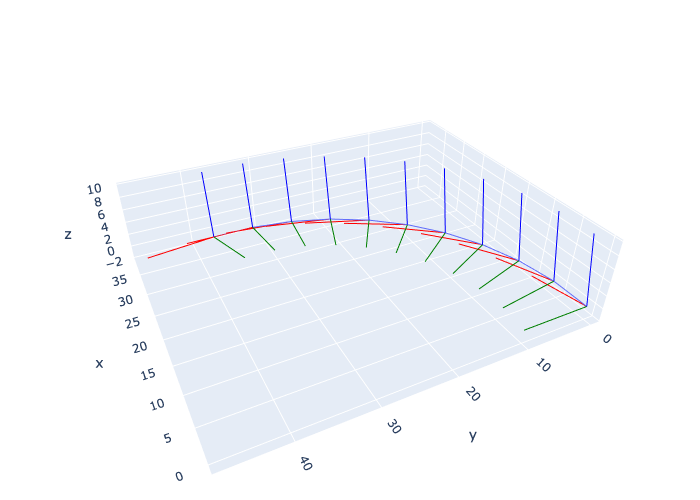

In [15]:
fig = px.line_3d(x=rn[0], y=rn[1], z=rn[2])
scale, labels = 10, ["F", "L", "U"]
for k in range(K+1):
    nTb = gtsam.Pose3(gtsam.Rot3(nRb[:,:,k]), rn[:,k]);
    fig.add_traces(axes(nTb, scale, labels))
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
camera = dict(eye=dict(x=-2, y=1, z=1.5))
fig.update_layout(scene_camera=camera, scene_aspectmode='data', showlegend=False)
fig.show()

You can see that the drone takes off in the positive X-direction (at right of figure, away from us), which is East in the ENU convention, and then gradually turns towards the North, which is indeed a counter-clockwise rotation around vertical!

**Exercises**

- Change the direction of the turn to the other side.
- Change the code to use different values for $\Delta t$ and observe the results.
- Change the initial forward orientation to be the *northern* direction.

## Full Rigid-Body Dynamics*

> Not hard to write down, but harder to understand.

Ultimately we need to move a quadrotor by provide forces through the four rotors, which will produce a force *and* a moment on the quadrotor body. These in turn will generate linear and angular accelerations, through the quadrotor **dynamics**.

Let us start with the famous Newton's law, with the acceleration $a$ written suggestively as $\dot{v}^n$, and immediately thinking in terms of force and velocity *vectors*:

$$
F^n = m \dot{v}^n
$$

Above the **mass** $m$ can be seen as a scalar *resisting* motion: the higher the mass, the higher the force needed to produce an acceleration in any dimension. Note that we could consider $m$ to be a diagonal matrix with the mass on the diagonal: acceleration is resisted the same way in all three axes, in whatever coordinate frame we choose.

The same is (approximately) true for rotational motion, using torque $\tau^b$ and angular velocity $\omega^b$,

$$
\tau^b \approx I \dot{\omega}^b
$$

and the **inertial matrix** $I$ is resisting angular motion.
Expressed in an FLU body coordinate frame, the inertial matrix $I$ is typically a diagonal matrix with "small-small-big" diagonal elements, as the motor masses are further away from the Z-axis than from the X and Y axes, and hence resist acceleration around the Z-axis more.
The approximation above is reasonable for small angular velocities $\omega^b$. 


What is still missing is how to translate from forces at the rotors to a force and moment on the *body*. In the body coordinate frame, the force equation is easy and we have seen it before:

$$
F^b_z = \sum_i f_i.
$$

Above the forces $f_i$ at the rotors are all oriented along the body Z-coordinate axis (up!) and hence when we sum them we get a single force component $F^b_z$ along the body Z-axis.

The torque $\tau^b$ in the body frame is a bit more involved, and is a function of the force vector $f$. The exact formula depends on the geometry of the rotors. For example, for a 4-motor “X” configuration with motor 1 forward left and numbered clockwise, we obtain

$$
\tau^b = \begin{bmatrix}
l(f_{1}-f_{2}-f_{3}+f_{4})\\
l(f_{1}+f_{2}-f_{3}-f_{4})\\
\kappa (f_{1}-f_{2}+f_{3}-f_{4})\\
\end{bmatrix}
$$

where $l$ is the distance from the rotors to the center of mass, and $\kappa$ is a torque constant.
From this equation you can see that a quadrotor is like a differential drive robot but with *two* differential axes. Controlling it is easy in principle: *tilt, then move*. A part of $F^b_z$ will be used to keep the quadrotor flying, the other part will be used to overcome drag.

The final piece of the puzzle is how exactly the rotors generate the individual forces $f_i$. We will not discuss that in detail here, but suffice to say that they are well understood functions of the rotor speed. Each motor also generates a small moment $\kappa f_i$ around it's rotor axis,  proportional to the force with proportionality constant $\kappa$. The rotation direction for each rotor determines which sign to use to calculate the Z-component of the body torque $\tau^b$.

**Exercises**

- Try to deeply understand the torque matrix above.
- Try to create the torque matrix for a 4-motor "+" configuration.

## Gyroscopic effects*

> Dotting the I's.

If a quadrotor undergoes large angular velocities, we cannot ignore gyroscopic effects and we have to modify the rotational dynamics equation above to

$$
\tau^b = I \dot{\omega}^b - \omega^b \times I \omega^b,
$$

where $\times$ is the cross-product. The second term is a set of quadratic components in the angular velocity $\omega^b$ and that is why for small angular velocities they can be ignored. In fact, in many cases the orientation of a quadrotor is *actively controlled* to stay constant during hovering or in fast forward flight, and it is only in complicated maneuvers that large angular velocities occur.